## Data gridding

In [1]:
from GG_mthesis import *
%matplotlib inline

In [2]:
sns.set_style('whitegrid')
sns.set_palette('colorblind')
sns.set(font_scale=1.2)

In [57]:
#define the path
path = '.\\data\\02_intermediate\\tsg_orchestra\\b1903933_preprocessed.nc'

#open the dataset with the defined path
ds = xr.open_dataset(path) 

In [62]:
#doesnt really work
#ds['time1'] = xr.DataArray(np.array(ds.time), dims='time')
#ds.time1.attrs = {'long_name': 'Chronological DateTime Date',
 #'standard_name': 'time',
 #'ancillary_variables': 'TIME_SEADATANET_QC',
 #'axis': 'T',
 #'valid_min': 0.0,
 #'valid_max': 2500000.0,
 #'sdn_parameter_urn': 'SDN:P01::CJDY1101',
 #'sdn_parameter_name': 'DateTime (chronological)',
 #'sdn_uom_name': 'Days',
 #'sdn_uom_urn': 'SDN:P06::UTAA'}

In [60]:
#First I create the relevant grid (start to end, 500m steps).
distance_grid = np.arange(0, float(np.max(ds.distance_cum)), 500)

#Make the cumulative distance the dimension as I want to use it as the interpolating dimension
ds = ds.swap_dims({'time':'distance_cum'})

#Here I create new gridded dataset, one with a linear interpolation and another one with a cubic interpolation.
ds_gridded = ds.interp(distance_cum = distance_grid, method='linear')
#ds_gridded_cubic = ds.interp(distance_cum = distance_grid, method='cubic')

In [61]:
ds_gridded

<xarray.Dataset>
Dimensions:             (distance_cum: 1951)
Coordinates:
    lat                 (distance_cum) float64 -52.5 -52.51 ... -61.19 -61.2
    lon                 (distance_cum) float64 -58.17 -58.17 ... -57.09 -57.09
    depth               (distance_cum) float64 6.5 6.5 6.5 6.5 ... 6.5 6.5 6.5
  * distance_cum        (distance_cum) float64 0.0 500.0 ... 9.745e+05 9.75e+05
Data variables:
    SP                  (distance_cum) float64 33.69 33.69 33.7 ... 33.93 33.93
    T                   (distance_cum) float64 7.405 7.413 7.392 ... 0.3259 0.32
    temp_hull_diff      (distance_cum) float64 -0.0176 -0.02303 ... -0.008183
    temp_tsg_hull_diff  (distance_cum) float64 0.6873 0.7032 ... 0.8807 0.8897
    pressure            (distance_cum) float64 6.558 6.558 6.558 ... 6.563 6.563
    SA                  (distance_cum) float64 33.85 33.85 33.85 ... 34.1 34.09
    CT                  (distance_cum) float64 7.416 7.424 ... 0.3305 0.3246
    rho_pot             (distance_cum) float64 1.026e+03 1.026e+03 ... 1.027e+03
Attributes:
    date_update:  2020-07-31T01:05:54+0100
    comment:      
    Conventions:  SeaDataNet_1.0 CF-1.6
    featureType:  trajectory
    title:        SeaDataNet NETCDF TRAJECTORY Climate Forecast 1.6 - GENERAT...

In [12]:
#Let's calculate the buoyancy at each point
g = 9.81 #m s-2
rho_0 = 1027 #kg m-3

#from Vallis the buoyancy is related to density through: b = -g delta(rho)/rho_0
ds_gridded['b'] = -(g/rho_0)*(ds_gridded.rho_pot-rho_0)
ds_gridded['b'].attrs = {
    'long_name': 'buoyancy',
    'standard_name': 'b',
    'units': 'N',
    'description': 'Sea pressure from height using gsw.'}



In [13]:
#The horizontal buoyancy gradient then is:
bx = []
for i in range(len(ds_gridded.b)-1):
    bx.append((ds_gridded.b[i+1] - ds_gridded.b[i])/1000)
#As the submesoscale fronts are anisotropic, we are not interested in the sign and can take the absolute value.
bx = np.abs(bx)

[Text(0, 0.5, 'Horizontal buoyancy gradient ($s^{-2}$)'),
 Text(0.5, 0, 'Distance (km)')]

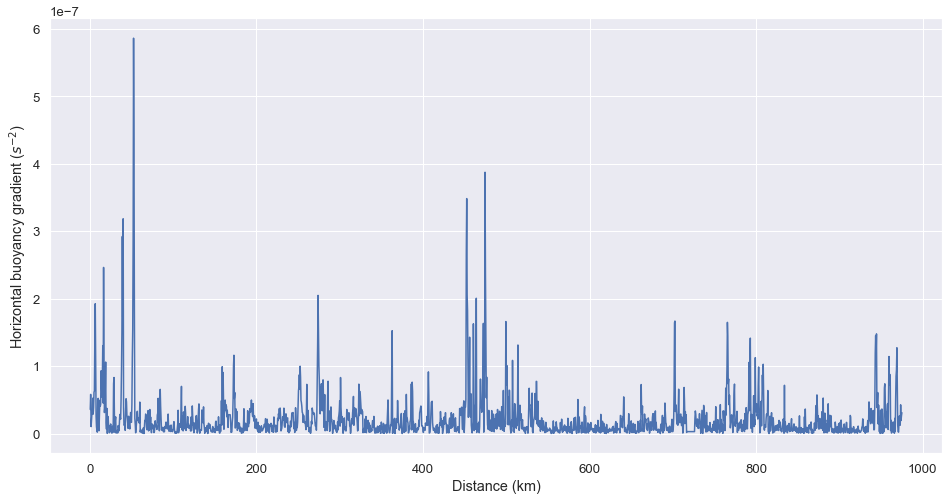

In [16]:
fig, ax = plt.subplots(figsize=(16,8))

sns.lineplot(x=ds_gridded.distance_cum[1:]/1000, y=bx)
ax.set(xlabel='Distance (km)', ylabel='Horizontal buoyancy gradient ($s^{-2}$)')

In [18]:
#We can safe the gridded data with the calculated buoyancy gradient.
path_to = '.\\data\\03_processed\\tsg_orchestra\\b1903933_gridded.nc'
ds_gridded.to_netcdf(path_to)